## Imports

In [28]:
import pandas as pd
import numpy as np
from tqdm import tqdm

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split

from category_encoders.cat_boost import CatBoostEncoder

# Part 1.

## Reading data

In [29]:
user_data = pd.read_csv('data/kkbox-music-recommendation-challenge/members.csv')
item_data = pd.read_csv('data/kkbox-music-recommendation-challenge/songs.csv')
train = pd.read_csv('data/kkbox-music-recommendation-challenge/train.csv')
test = pd.read_csv('data/kkbox-music-recommendation-challenge/test.csv')
extra_item_data = pd.read_csv('data/kkbox-music-recommendation-challenge/song_extra_info.csv')

## Data preprocessing; Feature engineering

In [30]:
def get_year(isrc):
    if pd.isnull(isrc):
        return np.nan
    else:
        if int(str(isrc)[5:7]) > 17:
            temp =  1900+int(str(isrc)[5:7])
        else:
            temp = 2000+int(isrc[5:7])
        return temp

extra_item_data['year'] = extra_item_data['isrc'].apply(lambda x: get_year(x))
extra_item_data.head()

,song_id,name,isrc,year
0,LP7pLJoJFBvyuUwvu+oLzjT+bI+UeBPURCecJsX1jjs=,我們,TWUM71200043,2012.0
1,ClazTFnk6r0Bnuie44bocdNMM3rdlrq0bCGAsGUWcHE=,Let Me Love You,QMZSY1600015,2016.0
2,u2ja/bZE3zhCGxvbbOB3zOoUjx27u40cf5g09UXMoKQ=,原諒我,TWA530887303,2008.0
3,92Fqsy0+p6+RHe2EoLKjHahORHR1Kq1TBJoClW9v+Ts=,Classic,USSM11301446,2013.0
4,0QFmz/+rJy1Q56C1DuYqT9hKKqi5TUqx0sN0IwvoHrw=,愛投羅網,TWA471306001,2013.0


In [31]:
# get number of membership days
# leave only year in expiration_date and registration_init_time columns

user_data['expiration_date'] = pd.to_datetime(user_data['expiration_date'], format='%Y%m%d')
user_data['registration_init_time'] = pd.to_datetime(user_data['registration_init_time'], format='%Y%m%d')
user_data['membership_days'] = user_data['expiration_date'].subtract(user_data['registration_init_time']).dt.days.astype(int)
user_data['registration_year'] = user_data['registration_init_time'].dt.year
user_data['expiration_year'] = user_data['expiration_date'].dt.year
user_data.drop(columns = ['registration_init_time' , 'expiration_date'] , inplace = True)
user_data.head()

,msno,city,bd,gender,registered_via,membership_days,registration_year,expiration_year
0,XQxgAYj3klVKjR3oxPPXYYFp4soD4TuBghkhMTD4oTw=,1,0,NaN,7,2223,2011,2017
1,UizsfmJb9mV54qE9hCYyU07Va97c0lCRLEQX3ae+ztM=,1,0,NaN,7,725,2015,2017
2,D8nEhsIOBSoE6VthTaqDX8U6lqjJ7dLdr72mOyLya2A=,1,0,NaN,4,457,2016,2017
3,mCuD+tZ1hERA/o5GPqk38e041J8ZsBaLcu7nGoIIvhI=,1,0,NaN,9,1,2015,2015
4,q4HRBfVSssAFS9iRfxWrohxuk9kCYMKjHOEagUMV6rQ=,1,0,NaN,4,138,2017,2017


In [32]:
train_full = (
    train
    .merge(right=user_data, 
           how='left', 
           on='msno')
    .merge(right=item_data,
           how='left',
           on='song_id')
    .merge(right=extra_item_data,
           how='left',
           on='song_id')
)

In [33]:
del train, user_data, item_data, extra_item_data

In [34]:
print(train_full.shape)

(7377418, 22)


In [35]:
# fill nans in song_length and language columns

train_full['song_length'].fillna(train_full['song_length'].mean() , inplace = True)
train_full['song_length'] = train_full['song_length'].astype(np.uint32)
train_full['language'].fillna(train_full['language'].mode().values[0] , inplace= True)
train_full['language'] = train_full['language'].astype(np.int8)

In [36]:
def genre_count(genre):
    if genre == 'no_genre_id':
        return 0
    else :
        return genre.count('|') + 1
    
def artist_count(art):
    if art=='no_artist_name':
        return 0
    else:
        return art.count('|') + art.count('/') + art.count('//') + art.count(';') + 1
    
def  count_composer(comp):
    if comp=='no_composer':
        return 0
    else:
        return comp.count('|') + comp.count('/') + comp.count('//') + comp.count(';') + 1

def  count_lyricist(lyr):
    if lyr=='no_lyricist':
        return 0
    else:
        return lyr.count('|') + lyr.count('/') + lyr.count('//') + lyr.count(';') + 1

In [37]:
# calc genres per row

print(train_full['genre_ids'].isnull().value_counts() / train_full.shape[0])
train_full['genre_ids'].fillna('no_genre_id' , inplace= True)
train_full['genre_ids_count'] = train_full['genre_ids'].apply(lambda x: genre_count(x)).astype(np.int8)

False    0.983944
True     0.016056
Name: genre_ids, dtype: float64


In [38]:
# calc artists per row

train_full['artist_name'].fillna('no_artist_name', inplace = True)
train_full['artist_count'] = train_full['artist_name'].apply(lambda x : artist_count(x)).astype(np.int8)

In [39]:
# calc composers per row

train_full['composer'].fillna('no_composer',inplace=True)
train_full['composer_count'] = train_full['composer'].apply(lambda x: count_composer(x)).astype(np.int8)

In [40]:
# calc lyricists per row

train_full['lyricist'].fillna('no_lyricist',inplace=True)
train_full['lyricist_count'] = train_full['lyricist'].apply(lambda x: count_lyricist(x)).astype(np.int8)

In [41]:
# add column with number of time song was played

dict_count_song_played_train = {k: v for k, v in train_full['song_id'].value_counts().iteritems()}
dict_count_song_played_test = {k: v for k, v in test['song_id'].value_counts().iteritems()}

def return_number_played(x):
    try:
        return dict_count_song_played_train[x]
    except KeyError:
        try:
            return dict_count_song_played_test[x]
        except KeyError:
            return 0

train_full['number_of_time_played'] = train_full['song_id'].apply(lambda x: return_number_played(x))


In [42]:
# get user activity info

dict_user_activity = {k:v for k,v in pd.concat([train_full['msno'] , test['msno']] , axis=0).value_counts().iteritems()}

def return_user_activity(x):
    try:
        return dict_user_activity[x]
    except KeyError:
        return 0

train_full['user_activity_msno'] = train_full['msno'].apply(lambda x: return_user_activity(x))


In [43]:
# fill song name nans with mode name of artist songs

def song_fillna(x):
    val_c = x.value_counts()
    if val_c.shape[0] > 0:
        return x.value_counts().index[0]
    
    else:
        return 'No song name'

In [44]:
freq_songs_by_artist = train_full.groupby('artist_name')['name'].apply(song_fillna).reset_index()
artist_dict = dict(zip(freq_songs_by_artist.artist_name, freq_songs_by_artist.name))

In [45]:
mask = train_full['name'].isnull()
train_full.loc[mask, 'name'] = train_full.loc[mask, 'artist_name'].map(artist_dict)

### Cat features preprocessing

In [46]:
from sklearn.model_selection import GroupShuffleSplit

In [65]:
y = train_full['target']
X = train_full.drop(columns='target') 

In [66]:
to_drop = ['msno', 'song_id', 'isrc', 'name']

In [67]:
cat_features = ['source_system_tab', 'source_screen_name', 'source_type', 'artist_name',
                'composer', 'lyricist', 'gender', 'genre_ids', 'language', 'city', 'registered_via']

num_features = set(X.columns) - set(cat_features) - set(to_drop)
print(num_features)

{'membership_days', 'expiration_year', 'composer_count', 'number_of_time_played', 'artist_count', 'user_activity_msno', 'bd', 'genre_ids_count', 'song_length', 'lyricist_count', 'registration_year', 'year'}


In [68]:
X.loc[:,num_features] = X[num_features].fillna(X[num_features].median().iloc[0])
X.loc[:,cat_features] = X[cat_features].fillna(X[cat_features].mode().iloc[0])

In [69]:
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())])

categorical_transformer = Pipeline(steps=[
    ('encoder', CatBoostEncoder())])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, list(num_features)),
        ('cat', categorical_transformer, list(cat_features))])

ppl = Pipeline(steps=[('preprocessor', preprocessor)])

### UPD: per user train-test split + XGBoost Ranker + AUC ROC per user + NDCG

In [76]:
from sklearn.model_selection import GroupShuffleSplit

gss = GroupShuffleSplit(test_size=.1, n_splits=1, random_state = 7).split(X, groups=X['msno'])

X_train_inds, X_test_inds = next(gss)

train_data= X.iloc[X_train_inds]
X_train = train_data.loc[:, ~train_data.columns.isin(to_drop)]
y_train = y.iloc[X_train_inds]

groups = train_data.groupby('msno').size().to_frame('size')['size'].to_numpy()

test_data= X.iloc[X_test_inds]

X_test = test_data.loc[:, ~test_data.columns.isin(['song_id', 'isrc', 'name'])]
y_test = y.iloc[X_test_inds]

In [77]:
X_train.shape

(6646472, 23)

In [78]:
X_test.shape

(730946, 24)

In [79]:
X_train_processed = ppl.fit_transform(X_train, y_train)
X_train = pd.DataFrame(columns=list(num_features)+list(cat_features), data=X_train_processed)
print(X_train.shape)

x_test_ids = X_test['msno']
X_test_processed = ppl.transform(X_test.drop(columns='msno'))
X_test = pd.DataFrame(columns=list(num_features)+list(cat_features), data=X_test_processed)
print(X_test.shape)

(6646472, 23)
(730946, 23)


In [81]:
params = {'objective': 'rank:pairwise', 'eta': 0.1, 'gamma': 1.0,
          'min_child_weight': 0.1, 'max_depth': 6}

import xgboost as xgb

model = xgb.XGBRanker(  
    objective='rank:pairwise',
    random_state=42, 
    learning_rate=0.1,
    colsample_bytree=0.9, 
    eta=0.05, 
    max_depth=6, 
    n_estimators=110, 
    subsample=0.75 
)

model.fit(X_train, y_train, group=groups, verbose=True)

XGBRanker(base_score=0.5, booster='gbtree', colsample_bylevel=1,
          colsample_bynode=1, colsample_bytree=0.9, eta=0.05, gamma=0,
          gpu_id=-1, importance_type='gain', interaction_constraints='',
          learning_rate=0.1, max_delta_step=0, max_depth=6, min_child_weight=1,
          missing=nan, monotone_constraints='()', n_estimators=110, n_jobs=8,
          num_parallel_tree=1, random_state=42, reg_alpha=0, reg_lambda=1,
          scale_pos_weight=None, subsample=0.75, tree_method='approx',
          validate_parameters=1, verbosity=None)

In [83]:
X_test['msno'] = x_test_ids

In [95]:
preds = predict(model, X_test.loc[:, ~X_test.columns.isin(['msno'])])

In [117]:
def dcg(preds, labels):
    out = np.sum(labels[np.argsort(-preds)] / np.log2(1 + np.arange(1, len(preds) + 1)))
    return out

def idcg(preds, labels):
    out = np.sum(-np.sort(-labels) / np.log2(1 + np.arange(1, len(preds) + 1)))
    return out

def ndcg(queries, preds, labels):
    ndcgs = []
    for query_id in np.unique(queries):
        mask = (queries == query_id)
        dcg_q = dcg(preds[mask], labels[mask])
        idcg_q = idcg(preds[mask], labels[mask])
        if idcg_q > 0:
            ndcgs.append(dcg_q / idcg_q)

    return np.mean(ndcgs)

In [114]:
from sklearn.metrics import roc_auc_score

def auc_user(queries, preds, labels):
    auc = []
    for query_id in np.unique(queries):
        try:
            mask = (queries == query_id)
            auc.append(roc_auc_score(labels[mask], preds[mask]))
        except:
            pass

    return np.mean(auc)

In [118]:
ndcg(x_test_ids.values, preds, y_test.values)

0.8345363211081881

In [119]:
auc_user(x_test_ids.values, preds, y_test.values)

0.6366436349652603

Метрики для юзеров получились пониже, чем в случае с метриками для обычной классификации (они ниже), но тем не менее - все равно ок

### --Дальше всё как было раньше--

In [24]:
# train-test split

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=21)

In [25]:
X_train_processed = ppl.fit_transform(X_train, y_train)
X_train = pd.DataFrame(columns=list(num_features)+list(cat_features), data=X_train_processed)
print(X_train.shape)

(5533063, 23)


In [26]:
X_test_processed = ppl.transform(X_test)
X_test = pd.DataFrame(columns=list(num_features)+list(cat_features), data=X_test_processed)
print(X_test.shape)

(1844355, 23)


In [27]:
del X, y

## GBDT training

In [19]:
import xgboost as xgb
from sklearn.metrics import roc_auc_score
from xgboost import cv

In [28]:
xgb_train = xgb.DMatrix(X_train, y_train)
xgb_test = xgb.DMatrix(X_test, y_test)

In [29]:
params = {
        'objective': 'binary:logistic',
        'learning_rate': 0.3 ,
        'max_bin': 256,
        'max_depth': 10,
}

In [30]:
bst = xgb.train(params, xgb_train, 30)

[16:12:41] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [31]:
roc_auc_score(y_test, bst.predict(xgb_test))

0.736921148352364

In [35]:
X_train.to_pickle('data/X_train.pickle')
y_train.to_pickle('data/y_train.pickle')
X_test.to_pickle('data/X_test.pickle')
y_test.to_pickle('data/y_test.pickle')

In [94]:
X_train = pd.read_pickle('data/X_train.pickle')
y_train = pd.read_pickle('data/y_train.pickle')
X_test = pd.read_pickle('data/X_test.pickle')
y_test = pd.read_pickle('data/y_test.pickle')

In [37]:
import pickle
file_name = "xgb.pkl"

# save
with open(file_name, "wb") as f:   
    pickle.dump(bst, f)


In [7]:
# load
import pickle
file_name = "xgb.pkl"
with open(file_name, "rb") as f:
    bst = pickle.load(f)

In [34]:
# cv

xgb_cv = cv(dtrain=xgb_train, 
            params=params, 
            nfold=5,
            num_boost_round=40, 
            early_stopping_rounds=20, 
            metrics="auc", 
            as_pandas=True, 
            seed=123)

In [35]:
xgb_cv

,train-auc-mean,train-auc-std,test-auc-mean,test-auc-std
0,0.705728,0.000111,0.703903,0.000215
1,0.709136,0.000102,0.707131,0.000212
2,0.711579,0.000156,0.709353,0.000249
3,0.713222,0.000136,0.710727,0.000180
4,0.714497,0.000256,0.711735,0.000300
5,0.716055,0.000167,0.712972,0.000206
6,0.717415,0.000146,0.714054,0.000191
7,0.718775,0.000192,0.715111,0.000182
8,0.719975,0.000308,0.715986,0.000254
9,0.721241,0.000362,0.716938,0.000302


### Shap values

In [8]:
import shap
shap.initjs()

In [9]:
explainer = shap.TreeExplainer(bst)

In [14]:
# беру только 50к, иначе длится бесконечно долго
shap_values = explainer.shap_values(X_train[:50000])

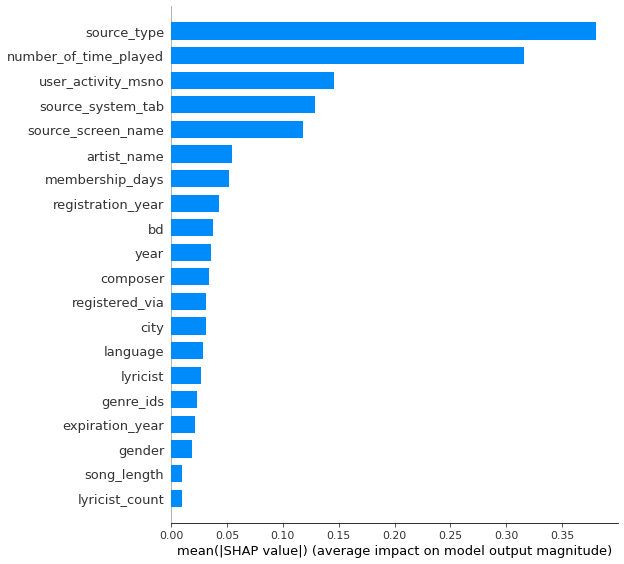

In [15]:
shap.summary_plot(shap_values, X_train, plot_type="bar")

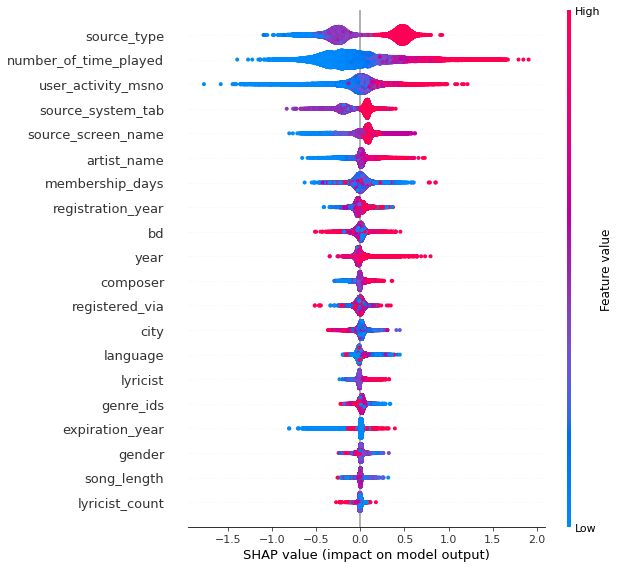

In [16]:
shap.summary_plot(shap_values, X_train[:50000])

### Bayesian parameters optimization

Подберем гиперпараметры на некотором подмножестве обучающей выборки

In [17]:
from bayes_opt import BayesianOptimization

In [18]:
# take subset of data

dtrain_optimize = xgb.DMatrix(X_train[:200000], y_train[:200000])

In [19]:
AUCbest = 0
ITERbest = 0

def optimize_xgboost(
          max_depth,
          gamma,
          min_child_weight,
          max_delta_step,
          subsample,
          colsample_bytree,
          lr
         ):

    global AUCbest
    global ITERbest

    params = {
              'max_depth' : int(max_depth),
              'gamma' : gamma,
              'eta' : 0.1,
              'objective' : 'binary:logistic',
              'nthread' : 46,
              'silent' : True,
              'eval_metric': 'auc',
              'subsample' : max(min(subsample, 1), 0),
              'colsample_bytree' : max(min(colsample_bytree, 1), 0),
              'min_child_weight' : min_child_weight,
              'max_delta_step' : int(max_delta_step),
              'seed' : 228,
              'learning_rate': lr,
              'max_bin': 256,
              }

    folds = 5
    cv_score = 0
    xgbc = xgb.cv(
                    params,
                    dtrain_optimize,
                    num_boost_round = 400,
                    stratified = True,
                    nfold = folds,
                    early_stopping_rounds = 100,
                    metrics = 'auc',
                    show_stdv = True
               )
    val_score = xgbc['test-auc-mean'].iloc[-1]
    train_score = xgbc['train-auc-mean'].iloc[-1]
    if ( val_score > AUCbest ):
        AUCbest = val_score
        ITERbest = len(xgbc)

    return (val_score * 2) - 1

In [20]:
xgb_bo = BayesianOptimization(optimize_xgboost, {
                                     'max_depth': (5, 15),
                                     'gamma': (0.001, 10.0),
                                     'min_child_weight': (0, 20),
                                     'max_delta_step': (0, 10),
                                     'subsample': (0.4, 1.0),
                                     'colsample_bytree' :(0.4, 1.0),
                                     'lr': (0.01, 0.5)
})

In [21]:
xgb_bo.maximize(init_points=3, n_iter=10, acq='ei', xi=0.0)

|   iter    |  target   | colsam... |   gamma   |    lr     | max_de... | max_depth | min_ch... | subsample |
-------------------------------------------------------------------------------------------------------------
[17:09:25] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:09:26] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not u

[17:15:50] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:15:50] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


|  4        |  0.4002   |  0.4924   |  8.985    |  0.4333   |  0.3059   |  11.5     |  17.9     |  0.8939   |
[17:17:47] WARNING: 

[17:21:33] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:21:33] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:21:33] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/wor

[17:40:53] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


|  11       |  0.4161   |  0.4      |  1.752    |  0.01     |  3.822    |  13.23    |  10.82    |  1.0      |
[17:48:58] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:48:58] WARNING: 

In [22]:
xgb_bo.max

{'target': 0.41716679999999995,
 'params': {'colsample_bytree': 0.4,
  'gamma': 0.8199084350257906,
  'lr': 0.01,
  'max_delta_step': 0.9578527673141123,
  'max_depth': 15.0,
  'min_child_weight': 14.042189482546489,
  'subsample': 1.0}}

In [23]:
xgb_train = xgb.DMatrix(X_train, y_train)
xgb_test = xgb.DMatrix(X_test, y_test)

In [24]:
params = {
        'objective': 'binary:logistic',
        'colsample_bytree': 0.4,
        'gamma': 0.8199084350257906,
        'lr': 0.01,
        'max_delta_step': int(0.9578527673141123),
        'max_depth': int(15.0),
        'min_child_weight': 14.042189482546489,
        'max_bin': 256,
        'subsample': 1
}

bst2 = xgb.train(params, xgb_train, 50)

[18:11:21] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:541: 
Parameters: { lr } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:11:28] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [25]:
roc_auc_score(y_test, bst2.predict(xgb_test))

0.7724315664196599

С помощью подбора гиперпараметров получили небольшое увеличение рок-аук (+ 0.04)

# Part 2.

## Word2vec embeddings 

In [21]:
from gensim.models import Word2Vec
from collections import defaultdict
import multiprocessing

"Предложениями" для word2vec будем использовать {artist_name}_{song_name}

In [26]:
train_full['source_system_tab'] = train_full['source_system_tab'].astype('category')
train_full['source_system_tab'] = train_full['source_system_tab'].cat.add_categories('Unknown')
train_full['source_system_tab'].fillna('Unknown', inplace=True) 

In [31]:
song_sentences = defaultdict(list)
for i, row in tqdm(train_full[train_full['target'] == 1].iterrows(), total=train_full[train_full['target'] == 1].shape[0]):
    song_sentences[f"{row['msno']}_{row['source_system_tab']}"].append(f"{row['artist_name']}_{row['name']}")

100%|██████████| 3714656/3714656 [01:45<00:00, 35087.42it/s]


In [34]:
w2v = Word2Vec(min_count=2,
                 window=10,
                 vector_size=30,
                 negative=18,
                 sg=1,
                 workers=multiprocessing.cpu_count()-1)

In [35]:
sent = list(song_sentences.values())

In [32]:
w2v.build_vocab(sent)

In [36]:
w2v.build_vocab(sent)

w2v.train(sent, 
          total_examples=w2v.corpus_count, 
          epochs=10)

(36212421, 37146560)

### Similars 

In [37]:
w2v.init_sims(replace=True)

<ipython-input-37-dc91b3835df3>:1: DeprecationWarning: Call to deprecated `init_sims` (Gensim 4.0.0 implemented internal optimizations that make calls to init_sims() unnecessary. init_sims() is now obsoleted and will be completely removed in future versions. See https://github.com/RaRe-Technologies/gensim/wiki/Migrating-from-Gensim-3.x-to-4).
  w2v.init_sims(replace=True)


In [79]:
w2v.wv.most_similar(positive="Billie Eilish_Six Feet Under")

[("Sigala_Sweet Lovin'", 0.9059657454490662),
 ('Morgan Page_Open Heart', 0.8937579393386841),
 ('EDM Dance Music_Canibal Cove', 0.8855466246604919),
 ('Sebastien_Gold', 0.8803921937942505),
 ('Party Favor_Give It To Me Twice (feat. Sean Kingston & Rich The Kid)',
  0.8789194822311401),
 ("Imany_Don't Be so Shy (Filatov & Karas Remix)", 0.8739027380943298),
 ('Body Fitness Workout_Wake Me Up (125 BPM)', 0.8738633990287781),
 ('Jessica Ashley_24 Hours', 0.8738001585006714),
 ('Illenium_Fortress (feat. Joni Fatora)', 0.871831476688385),
 ('Robin Schulz_Sugar (feat. Francesco Yates)', 0.8710482716560364)]

In [66]:
w2v.wv.most_similar(positive="Beyoncé_Single Ladies (Put a Ring on It)")

[('CRAYON POP_Bar Bar Bar', 0.8268625736236572),
 ('Ylvis_The Fox (What Does The Fox Say?)', 0.8261861801147461),
 ('筷子兄弟_小蘋果 (新年Remix版)', 0.8135268688201904),
 ('王蓉 (Rollin Wang)_小雞小雞 (Chick Chick)', 0.799095094203949),
 ('PSY_Gangnam Style (강남스타일)', 0.7844070792198181),
 ('Aqua_Barbie Girl', 0.7697789669036865),
 ('謝金燕 (Jeannie Hsieh)_姐姐', 0.7570717930793762),
 ('順子 (Shunza)_Open Up', 0.753490686416626),
 ('Aqua_Doctor Jones', 0.7531718611717224),
 ('Christina Aguilera_Candyman (Candyman)', 0.752190887928009)]

In [52]:
w2v.wv.most_similar(positive="T.I._That's All She Wrote (feat. Eminem)")

[('Eminem_Beautiful', 0.9171540141105652),
 ('Eminem_Criminal', 0.9025917649269104),
 ('A$AP Rocky_PMW (All I Really Need)', 0.8999562859535217),
 ('G-Eazy_Some Kind Of Drug', 0.8960913419723511),
 ('Kanye West_Street Lights', 0.8933157324790955),
 ('Eminem_Rap God', 0.8932953476905823),
 ('Eminem_Bitch Please II', 0.8905491232872009),
 ('YoungQueenz_7-7-7', 0.8902435898780823),
 ('A$AP Rocky_Fashion Killa', 0.8891677260398865),
 ('Juicy J_Ballin', 0.888672411441803)]

In [59]:
w2v.wv.most_similar(positive="t.A.T.u._All About Us")

[('t.A.T.u._Loves Me Not', 0.8800712823867798),
 ('t.A.T.u._Not Gonna Get Us', 0.8671250343322754),
 ('t.A.T.u._All The Things She Said', 0.8502882719039917),
 ('t.A.T.u._30 Minutes', 0.8310107588768005),
 ('Miley Cyrus_Kicking And Screaming', 0.8165551424026489),
 ('t.A.T.u._Show Me Love', 0.7917230725288391),
 ('t.A.T.u._Friend or Foe', 0.7901233434677124),
 ('Beyoncé_Check On It', 0.7899307608604431),
 ('t.A.T.u._Dangerous And Moving (Intro)', 0.7731893658638),
 ('Britney Spears_Break The Ice(打破僵局)', 0.7678763270378113)]

Видно, что симилары вполне адекватные

In [22]:
# w2v.save('w2v.model')
w2v = Word2Vec.load('w2v.model')

### Recommender with word2vec embs

In [23]:
word_vectors = w2v.wv
print(len(word_vectors))

103764


In [32]:
userembed = {}

def get_user_embedding(row):
    user_name = f"{row['msno']}_{row['source_system_tab']}"
    
    if user_name in userembed:
        return userembed[user_name]
    
    embedding = np.zeros(30,)
    for song in song_sentences[user_name]:
        if song in word_vectors.key_to_index:
            embedding += w2v.wv.get_vector(song)
    
    userembed[user_name] = embedding
    return embedding

def get_item_embedding(row):
    song_name = f"{row['artist_name']}_{row['name']}"
    
    if song_name in word_vectors.key_to_index:
        return w2v.wv.get_vector(song_name)
    
    else:
        return np.zeros(30,)

In [33]:
user_embeddings = np.vstack(train_full.apply(get_user_embedding, axis=1))

In [34]:
item_embeddings = np.vstack(train_full.apply(get_item_embedding, axis=1))

In [35]:
scores = (item_embeddings * user_embeddings).mean(axis=1)
print(roc_auc_score(train_full.target, scores))

0.6844322246267087


Получили результаты хуже, но здесь только эмбеддинги w2v

### W2V + GBDT

In [36]:
train_full['w2v'] = scores

In [37]:
y = train_full['target']
X = train_full.drop(columns='target') 

In [38]:
to_drop = ['msno', 'song_id', 'isrc', 'name']
X = X.drop(columns=to_drop)

In [39]:
cat_features = ['source_system_tab', 'source_screen_name', 'source_type', 'artist_name',
                'composer', 'lyricist', 'gender', 'genre_ids', 'language', 'city', 'registered_via']

num_features = set(X.columns) - set(cat_features)

In [ ]:
X.loc[:,num_features] = X[num_features].fillna(X[num_features].median().iloc[0])
X.loc[:,cat_features] = X[cat_features].fillna(X[cat_features].mode().iloc[0])

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=21)

In [42]:
X_train_processed = ppl.fit_transform(X_train, y_train)
X_train = pd.DataFrame(columns=list(num_features)+list(cat_features), data=X_train_processed)
print(X_train.shape)

X_test_processed = ppl.transform(X_test)
X_test = pd.DataFrame(columns=list(num_features)+list(cat_features), data=X_test_processed)
print(X_test.shape)

(5533063, 24)
(1844355, 24)


In [43]:
xgb_train = xgb.DMatrix(X_train, y_train)
xgb_test = xgb.DMatrix(X_test, y_test)

In [44]:
params = {
        'objective': 'binary:logistic',
        'colsample_bytree': 0.4,
        'gamma': 0.8199084350257906,
        'lr': 0.01,
        'max_delta_step': int(0.9578527673141123),
        'max_depth': int(15.0),
        'min_child_weight': 14.042189482546489,
        'max_bin': 256,
        'subsample': 1
}

bst3 = xgb.train(params, xgb_train, 50)

[19:47:57] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:541: 
Parameters: { lr } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[19:48:03] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [45]:
roc_auc_score(y_test, bst3.predict(xgb_test))

0.8063234748791939

В результате получили лучшее значение метрики (+0.03)

In [46]:
import shap
shap.initjs()

In [47]:
explainer = shap.TreeExplainer(bst3)

In [50]:
shap_values = explainer.shap_values(X_train[:5000])

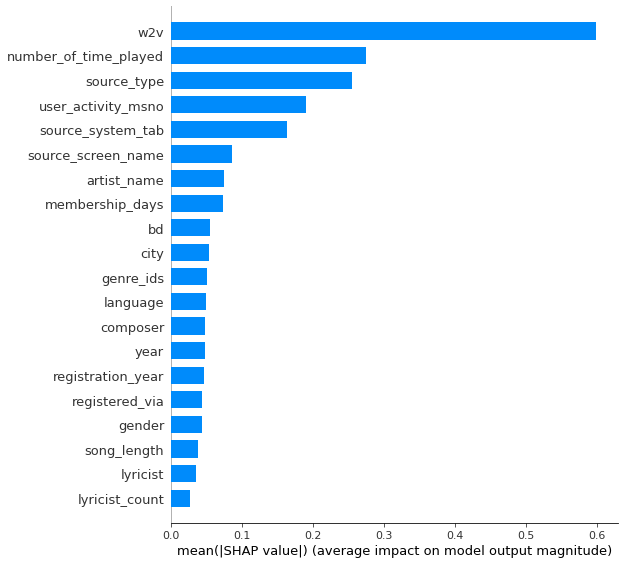

In [51]:
shap.summary_plot(shap_values, X_train[:5000], plot_type="bar")

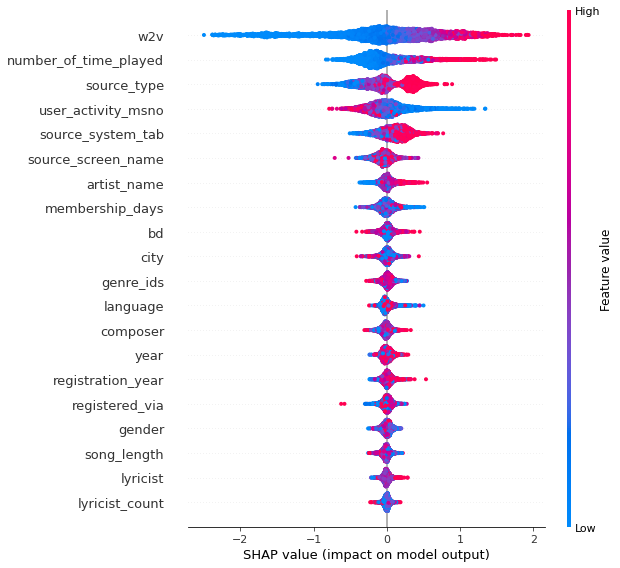

In [52]:
shap.summary_plot(shap_values, X_train[:5000])

Видим, что новая фича вносит наибольший вклад в аутпут модели